# Regression

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/bank-customer-churn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/bank_customer_churn.csv")
      .query("Exited == 1")  # subset churned customer
      .drop(labels=['CustomerId', 'RowNumber', 'Surname','Exited'], axis=1)
      # variables we will not need for this project
      # we will not need Exited since it has only 1
      )
cat_vars = ['Geography','Gender','IsActiveMember']
df[cat_vars] = df[cat_vars].astype(object)

print(df.shape)
df.head(3)


(2037, 10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,1,42,2,0.00,1,1,1,101348.88
2,502,France,1,42,8,159660.80,3,1,0,113931.57
5,645,Spain,0,44,8,113755.78,2,1,0,149756.71


In [5]:
robust_scaled_vars =['Age','Balance','CreditScore','EstimatedSalary',
                    #  'TenureByAge'
                     ]

# MP Pipeline: Regressor

## Create ML pipeline

In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor



def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("yeoJohnson", vt.YeoJohnsonTransformer(variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
         variables=[
            'Gender',
            'Geography',
            'IsActiveMember'
            ])),
        ("robust_scaler", RobustScaler(robust_scaled_vars)),
        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


Custom Class for hyperparameter optimisation

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': abs(min(scores)), # Absolute numbers to pick correct regressor
                'max_score': abs(max(scores)),
                'mean_score': abs(np.mean(scores)),
                'std_score': abs(np.std(scores)),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Tenure'], axis=1),
    df['Tenure'],
    test_size=0.3,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1425, 9) (1425,) 
* Test set: (612, 9) (612,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboo

Check results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
1,DecisionTreeRegressor,1.165527,0.992662,0.885306,0.096532
6,XGBRegressor,0.391009,0.314613,0.260002,0.053657
3,ExtraTreesRegressor,0.208514,0.154702,0.104581,0.037664
2,RandomForestRegressor,0.157536,0.091987,0.036233,0.041067
5,GradientBoostingRegressor,0.116215,0.074755,0.040759,0.02943
4,AdaBoostRegressor,0.027539,0.013686,0.000891,0.009567
0,LinearRegression,0.026009,0.013117,0.005468,0.013328


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [14]:
models_search = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

params_search = {
    "DecisionTreeRegressor": { 
     "model__max_depth": [2,5,10],
    "model__min_samples_split": [2,5,10],
    "model__min_samples_leaf": [2,3,5]
    }
}

Extensive GridSearch CV

In [15]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Check results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split
22,DecisionTreeRegressor,0.450229,0.314824,0.13117,0.113863,10,3,5
21,DecisionTreeRegressor,0.450229,0.314824,0.13117,0.113863,10,3,2
19,DecisionTreeRegressor,0.41444,0.314006,0.138992,0.101113,10,2,5
18,DecisionTreeRegressor,0.399169,0.312851,0.15327,0.092198,10,2,2
23,DecisionTreeRegressor,0.383871,0.286744,0.134559,0.08751,10,3,10
26,DecisionTreeRegressor,0.356553,0.281905,0.085849,0.100958,10,5,10
25,DecisionTreeRegressor,0.356553,0.281905,0.085849,0.100958,10,5,5
24,DecisionTreeRegressor,0.356553,0.281905,0.085849,0.100958,10,5,2
20,DecisionTreeRegressor,0.343838,0.255789,0.147142,0.071088,10,2,10
10,DecisionTreeRegressor,0.162007,0.099702,0.021204,0.049907,5,2,5


Check the best model

In [17]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'DecisionTreeRegressor'

Parameters for best model

In [18]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 2,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2}

Define the best regressor, based on search

In [19]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('yeoJohnson',
                 YeoJohnsonTransformer(variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography',
                                           'IsActiveMember'])),
                ('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=DecisionTreeRegressor(random_state=0))),
                ('model',
                 DecisionTreeRegressor(max_depth=2, min_samples_leaf=2,
                                       random_state=0))])

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


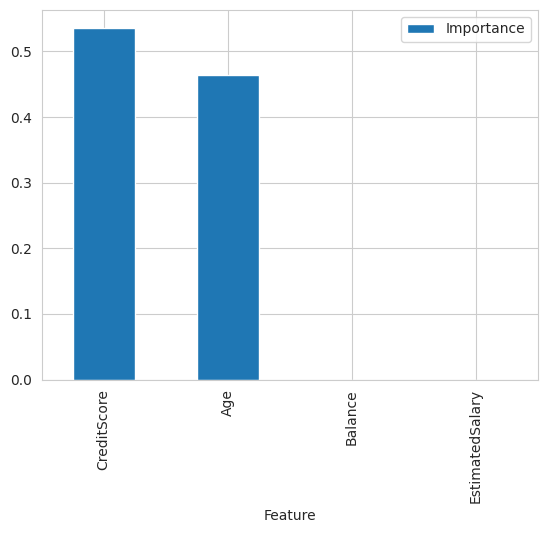

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.009
Mean Absolute Error: 2.517
Mean Squared Error: 8.559
Root Mean Squared Error: 2.926


* Test Set
R2 Score: -0.019
Mean Absolute Error: 2.531
Mean Squared Error: 8.72
Root Mean Squared Error: 2.953




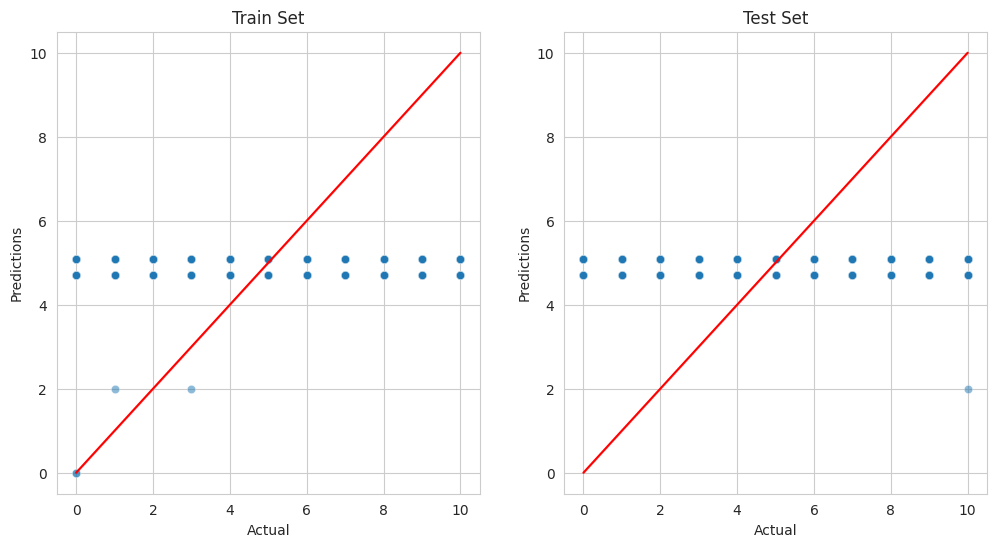

In [22]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Performance with Regressor does not meet Business requirements

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [24]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['Tenure'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(2037, 9) 
 <class 'numpy.ndarray'>


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Apply PCA separately to the scaled data

* The 9 components explain 100.0% of the data 



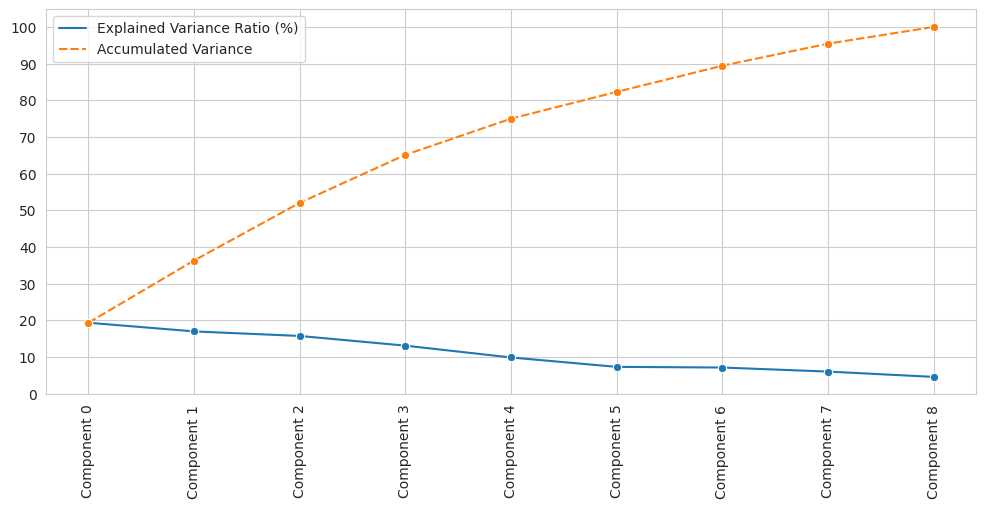

In [25]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 9


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


6 components needed to reach above 80% in accumulated variance

* The 6 components explain 82.29% of the data 



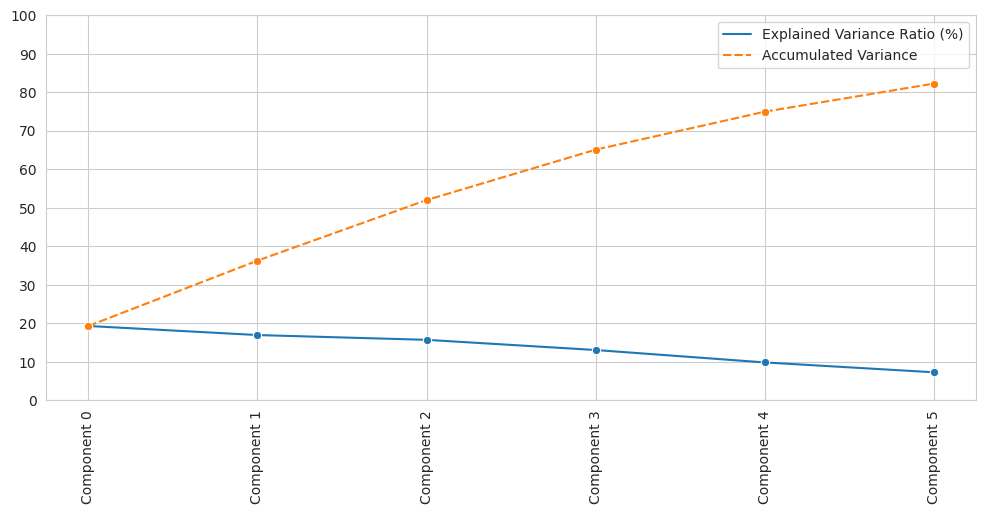

In [27]:
n_components = 6
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [28]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("yeoJohnson", vt.YeoJohnsonTransformer(variables=['Age','CreditScore'])),
       
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Gender', 'Geography'])),
        ("robust_scaler", RobustScaler(robust_scaled_vars)),
        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [29]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1425, 9) (1425,) 
* Test set: (612, 9) (612,)


### Use standard hyperparameters to find the most suitable model.

In [30]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [31]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboo

Check results

In [32]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
1,DecisionTreeRegressor,1.291521,0.92852,0.633783,0.213663
6,XGBRegressor,0.368537,0.229493,0.130791,0.089734
3,ExtraTreesRegressor,0.174266,0.087818,0.048634,0.045141
2,RandomForestRegressor,0.141647,0.061931,0.00069,0.049152
5,GradientBoostingRegressor,0.091388,0.034862,0.009011,0.029315
0,LinearRegression,0.022574,0.005861,0.006012,0.00981
4,AdaBoostRegressor,0.007925,0.001339,0.010568,0.005863


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [33]:
models_search = {
    "DecisionTreeRegressor":DecisionTreeRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "DecisionTreeRegressor":{
          'model__max_depth': [15],
    'model__min_samples_split': [4],
    'model__min_samples_leaf': [2]
    }
}

Extensive GridSearch CV

In [34]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Check results

In [35]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split
0,DecisionTreeRegressor,0.911203,0.690153,0.448527,0.164058,15,2,4


Check the best model

In [36]:
best_model = grid_search_summary.iloc[0,0]
best_model

'DecisionTreeRegressor'

Parameters for best model

In [37]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 4}

Define the best regressor

In [38]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('yeoJohnson',
                 YeoJohnsonTransformer(variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 DecisionTreeRegressor(max_depth=15, min_samples_leaf=2,
                                       min_samples_split=4, random_state=0))])

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.62
Mean Absolute Error: 1.269
Mean Squared Error: 3.28
Root Mean Squared Error: 1.811


* Test Set
R2 Score: -0.704
Mean Absolute Error: 3.125
Mean Squared Error: 14.585
Root Mean Squared Error: 3.819




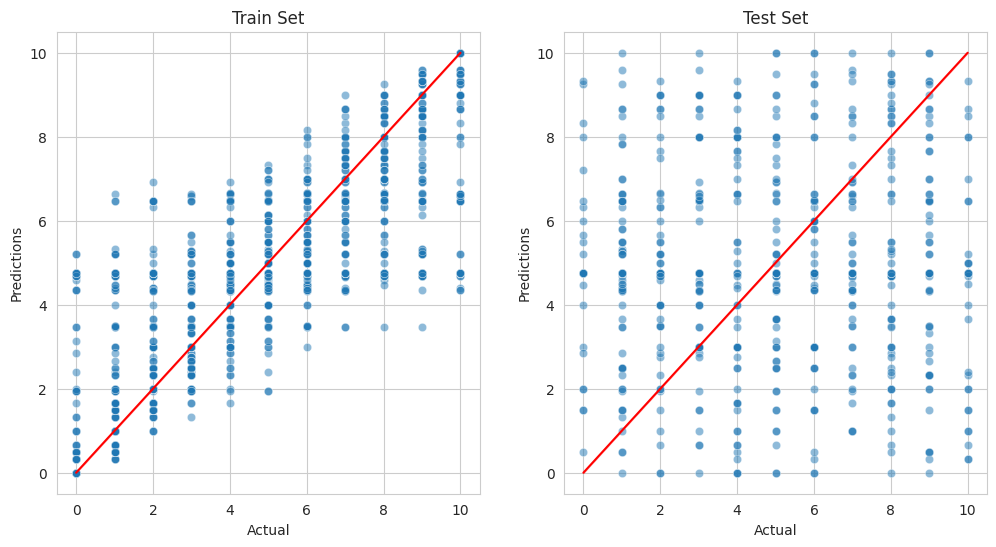

In [39]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

Regressor with PCA improved the performance on Train set but does not meet requirements on Test set

# Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

* The classes represent the following ranges: 
{'Tenure': [-inf, 5.0, inf]} 



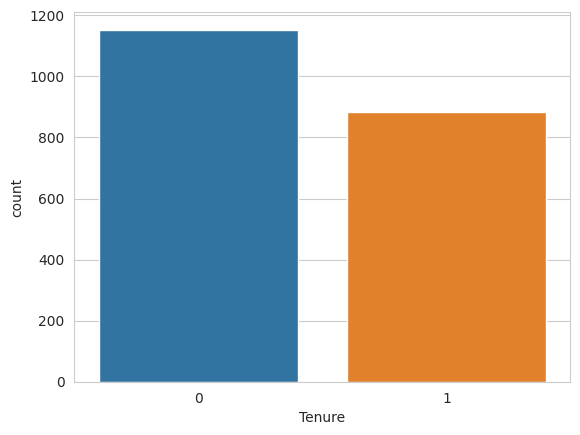

In [40]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=2, variables=['Tenure'])
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='Tenure')
plt.show()

In [41]:
df_clf.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,1,42,0,0.00,1,1,1,101348.88
2,502,France,1,42,1,159660.80,3,1,0,113931.57
5,645,Spain,0,44,1,113755.78,2,1,0,149756.71


## Rewrite ML Pipeline for Modelling

In [42]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
     ("yeoJohnson", vt.YeoJohnsonTransformer(variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender','Geography','IsActiveMember'])),
        ("robust_scaler", RobustScaler(robust_scaled_vars)),
        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


## Load algorithms for classification

In [43]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Tenure'], axis=1),
    df_clf['Tenure'],
    test_size=0.3,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1425, 9) (1425,) 
* Test set: (612, 9) (612,)


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [45]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [46]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Check results

In [47]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,AdaBoostClassifier,0.777778,0.81358,0.839506,0.021525
3,GradientBoostingClassifier,0.765432,0.796296,0.839506,0.026765
2,RandomForestClassifier,0.654321,0.671605,0.691358,0.016746
4,ExtraTreesClassifier,0.617284,0.664198,0.697531,0.027771
0,XGBClassifier,0.58642,0.619753,0.660494,0.028314
1,DecisionTreeClassifier,0.469136,0.57284,0.623457,0.057959


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [48]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
    'model__n_estimators': [10, 50, 100, 500, 1000, 5000]
    }
}


Extensive GridSearch CV

In [49]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Check results

In [50]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators
0,AdaBoostClassifier,0.722222,0.877778,0.975309,0.093322,10
1,AdaBoostClassifier,0.777778,0.81358,0.839506,0.021525,50
2,AdaBoostClassifier,0.759259,0.777778,0.796296,0.012346,100
3,AdaBoostClassifier,0.666667,0.671605,0.679012,0.004619,500
4,AdaBoostClassifier,0.62963,0.649383,0.666667,0.01259,1000
5,AdaBoostClassifier,0.58642,0.604938,0.641975,0.01952,5000



Check the best model

In [51]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model
* We are saving this content for later

In [52]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__n_estimators': 10}

Define the best clf pipeline

In [53]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('yeoJohnson',
                 YeoJohnsonTransformer(variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography',
                                           'IsActiveMember'])),
                ('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model', AdaBoostClassifier(n_estimators=10, random_state=0))])

## Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

* These are the 4 most important features in descending order. The model was trained on them: 
['Balance', 'EstimatedSalary', 'CreditScore', 'Age']


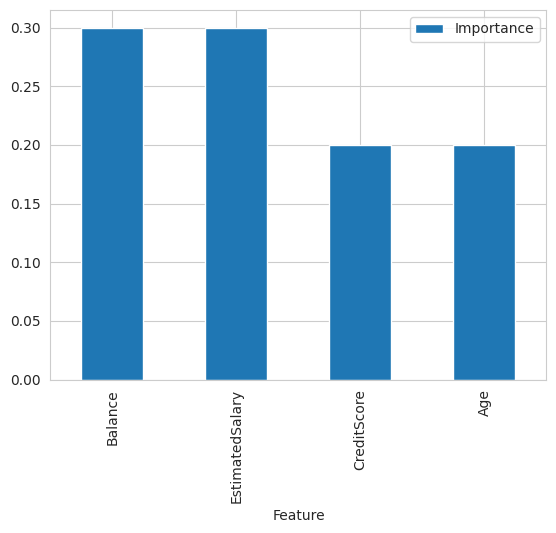

In [54]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

Custom Function

In [55]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Create Label Map to simplify reading

In [56]:
disc.binner_dict_['Tenure']

[-inf, 5.0, inf]

In [57]:
label_map = ['<5.0','+5.0']
label_map

['<5.0', '+5.0']

In [58]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual <5.0 Actual +5.0
Prediction <5.0         757         533
Prediction +5.0          53          82


---  Classification Report  ---
              precision    recall  f1-score   support

        <5.0       0.59      0.93      0.72       810
        +5.0       0.61      0.13      0.22       615

    accuracy                           0.59      1425
   macro avg       0.60      0.53      0.47      1425
weighted avg       0.60      0.59      0.50      1425
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual <5.0 Actual +5.0
Prediction <5.0         304         241
Prediction +5.0          39          28


---  Classification Report  ---
              precision    recall  f1-score   support

        <5.0       0.56      0.89      0.68       343
        +5.0       0.42      0.10      0.17       269

    accuracy                           0.54       612
   macro avg       0.49      0.50      0.43      

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <5 years), since we are interested to detect prospects that may churn soon. 
* It has weak performance for class 1 (+5 years)

In [59]:
pipeline_clf

Pipeline(steps=[('yeoJohnson',
                 YeoJohnsonTransformer(variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography',
                                           'IsActiveMember'])),
                ('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model', AdaBoostClassifier(n_estimators=10, random_state=0))])

# Refit pipeline with best features

## Rewrite Pipeline

In [60]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ('yeoJohnson',
                 vt.YeoJohnsonTransformer(variables=['Age', 'CreditScore'])),
        ('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary'])),
        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


## Split Train Test Set, only with best features

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Tenure'], axis=1),
    df_clf['Tenure'],
    test_size=0.3,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1425, 9) (1425,) 
* Test set: (612, 9) (612,)


Subset Best Features

In [62]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1425, 4) (1425,) 
* Test set: (612, 4) (612,)


,Balance,EstimatedSalary,CreditScore,Age
9138,185966.64,9445.42,578,59
8363,120043.13,132370.75,557,57
3938,118334.44,163147.99,483,41


## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [63]:
models_search

{'AdaBoostClassifier': AdaBoostClassifier(random_state=0)}

And the best parameters from the previous GridCV search

In [64]:
best_parameters

{'model__n_estimators': 10}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [65]:
params_search = {'AdaBoostClassifier':  {
      'model__n_estimators': [10]       # the value should be in []
}
}
params_search

{'AdaBoostClassifier': {'model__n_estimators': [10]}}

GridSearch CV

In [66]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Check results

In [67]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__n_estimators
0,AdaBoostClassifier,0.722222,0.877778,0.975309,0.093322,10


Check the best model

In [68]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Define the best clf pipeline

In [69]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('yeoJohnson',
                 YeoJohnsonTransformer(variables=['Age', 'CreditScore'])),
                ('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('model', AdaBoostClassifier(n_estimators=10, random_state=0))])

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['Balance', 'EstimatedSalary', 'CreditScore', 'Age']


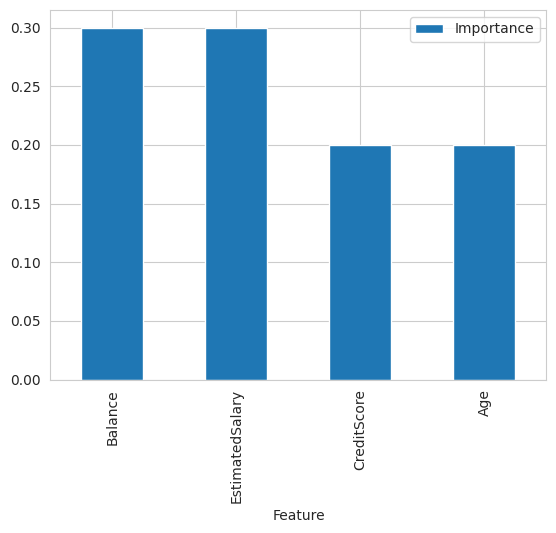

In [70]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

In [71]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                Actual <5.0 Actual +5.0
Prediction <5.0         757         533
Prediction +5.0          53          82


---  Classification Report  ---
              precision    recall  f1-score   support

        <5.0       0.59      0.93      0.72       810
        +5.0       0.61      0.13      0.22       615

    accuracy                           0.59      1425
   macro avg       0.60      0.53      0.47      1425
weighted avg       0.60      0.59      0.50      1425
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual <5.0 Actual +5.0
Prediction <5.0         304         241
Prediction +5.0          39          28


---  Classification Report  ---
              precision    recall  f1-score   support

        <5.0       0.56      0.89      0.68       343
        +5.0       0.42      0.10      0.17       269

    accuracy                           0.54       612
   macro avg       0.49      0.50      0.43      

Recall above 80% on both Train and Test set is within the Business Requirements. However the binning of the Tenure variable only allows for predictions of potential churning within five years. More customer Data is neccessary to significantly improve granularity of Tenure prediction. 

# Generate Files

Following files to be generated

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [72]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [73]:
X_train.head()

,Balance,EstimatedSalary,CreditScore,Age
9138,185966.64,9445.42,578,59
8363,120043.13,132370.75,557,57
3938,118334.44,163147.99,483,41
9393,111677.88,178827.30,670,43
9477,0.00,36548.00,655,41


In [74]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [75]:
y_train

9138    1
8363    0
3938    0
9393    1
9477    0
       ..
3957    0
5853    0
8030    0
2629    0
3240    0
Name: Tenure, Length: 1425, dtype: int64

In [76]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [77]:
X_test.head()

,Balance,EstimatedSalary,CreditScore,Age
4447,109062.28,140136.10,666,50
894,125884.95,54359.02,728,35
6479,0.00,149946.43,648,49
9750,70754.18,92920.04,708,51
9716,115730.71,185599.34,812,39


In [78]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [79]:
y_test

4447    1
894     1
6479    0
9750    1
9716    0
       ..
4243    0
6911    0
3370    1
8887    1
2540    1
Name: Tenure, Length: 612, dtype: int64

In [80]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting tenure

In [81]:
pipeline_clf

Pipeline(steps=[('yeoJohnson',
                 YeoJohnsonTransformer(variables=['Age', 'CreditScore'])),
                ('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('model', AdaBoostClassifier(n_estimators=10, random_state=0))])

In [82]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_tenure/v1/clf_pipeline.pkl']

## List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [83]:
label_map

['<5.0', '+5.0']

In [84]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

['outputs/ml_pipeline/predict_tenure/v1/label_map.pkl']

## Feature importance plot

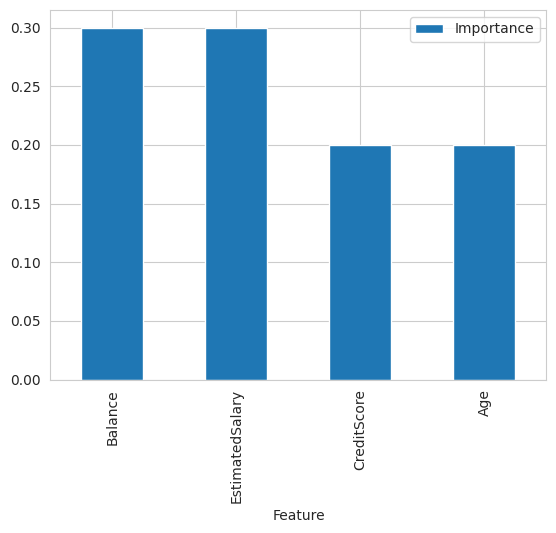

In [85]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

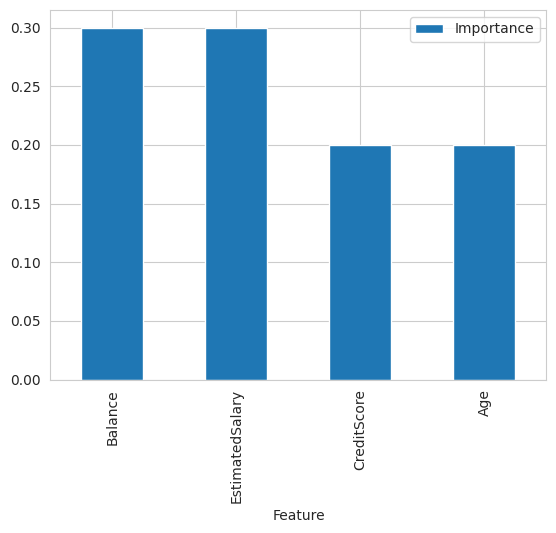

In [86]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---